# Predictions

I'll be using SARIMAX model to predict the sales for different time periods.
SARIMAX appears to be the most used model for time series (with seasonality) forecasting.

[Note: The data is clean, the only missing data (we know from the other notebook) is the postal code for a city. This will not be needed]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [1]:
import sys

sys.path.append('..')
from utils import *
from plots import *

In [3]:
# Load data
data = pd.read_csv('train.csv')
data.drop('Row ID', axis=1, inplace=True)

# Convert date to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True)
data['Ship Date'] = pd.to_datetime(data['Ship Date'], dayfirst=True)
data.sort_values('Order Date', inplace=True, ascending=True)
data.set_index('Order Date', inplace=True)

In [4]:
df = pd.DataFrame(data['Sales'])
df = df.resample('D').sum()
end = 10
train_data = df.iloc[:-end]

(-0.1, 0.3)

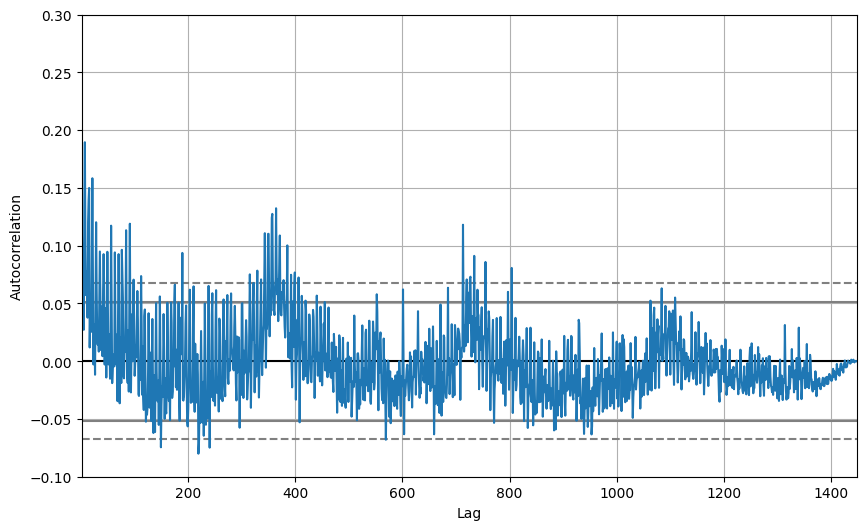

In [5]:
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(train_data['Sales'])

plt.ylim(-0.1, 0.3)

In [6]:
model = ARIMA(train_data['Sales'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 1448
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13233.345
Date:                Sat, 22 Jun 2024   AIC                          26478.691
Time:                        23:10:11   BIC                          26510.354
Sample:                    01-03-2015   HQIC                         26490.508
                         - 12-20-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7742      0.018    -43.004      0.000      -0.809      -0.739
ar.L2         -0.6131      0.024    -25.622      0.000      -0.660      -0.566
ar.L3         -0.4610      0.026    -17.620      0.0

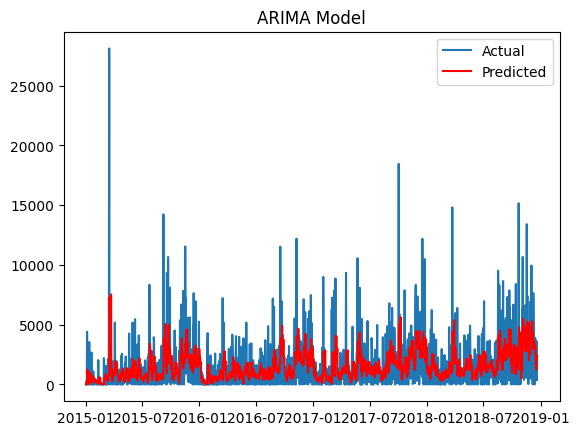

In [7]:

plt.figure()
plt.plot(train_data['Sales'], label='Actual')
plt.plot(model_fit.fittedvalues, color='red', label='Predicted')

plt.title('ARIMA Model')
plt.legend()

Residuals mean: 0    3.489613
dtype: float64
Residuals stdev: 0    2267.287208
dtype: float64


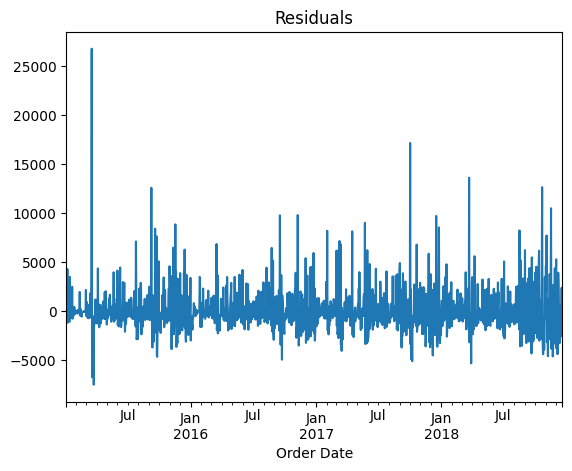

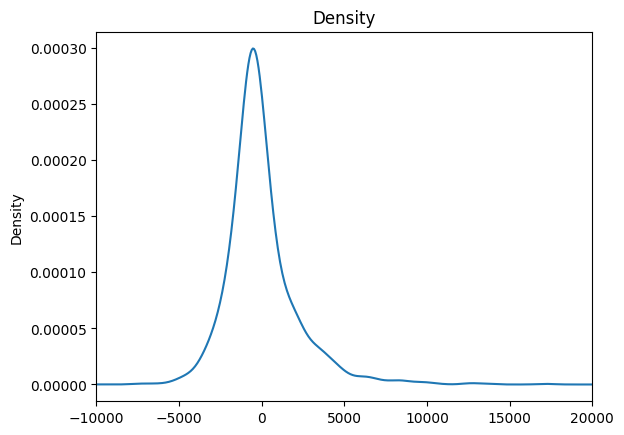

In [8]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(legend=False, title='Residuals')

residuals.plot(kind='density', title='Density', legend=False)
plt.xlim(-10000, 20000)

print(f"Residuals mean: {residuals.mean()}")
print(f"Residuals stdev: {residuals.std()}")

In [9]:
# The residuals distribution indicates a bias

In [10]:
# Predict next 7 days
steps = end
forecast = model_fit.forecast(steps=steps)
forecast_dates = pd.date_range(start=df.index[-end], periods=steps, freq='D')
forecast = pd.DataFrame(forecast.values, index=forecast_dates)
forecast.columns = ['Sales']

(array([17886., 17887., 17888., 17889., 17890., 17891., 17892., 17893.,
        17894., 17895.]),
 [Text(17886.0, 0, '2018-12-21'),
  Text(17887.0, 0, '2018-12-22'),
  Text(17888.0, 0, '2018-12-23'),
  Text(17889.0, 0, '2018-12-24'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17891.0, 0, '2018-12-26'),
  Text(17892.0, 0, '2018-12-27'),
  Text(17893.0, 0, '2018-12-28'),
  Text(17894.0, 0, '2018-12-29'),
  Text(17895.0, 0, '2018-12-30')])

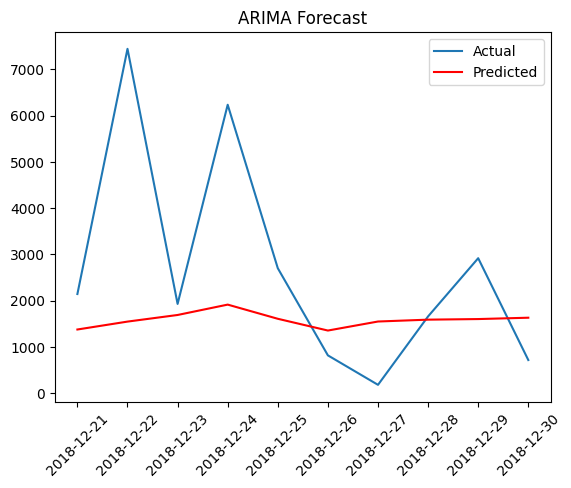

In [11]:
plt.figure()
plt.plot(df['Sales'].iloc[-end:], label='Actual')
plt.plot(forecast['Sales'], color='red', label='Predicted')
plt.title('ARIMA Forecast')

plt.legend()
plt.xticks(rotation=45)

In [12]:
# The predictions are not quite there. More parameter-tuning needed.
# I used ARIMA, this is not optimal
# SARIMAX should be used to account for seasonality trends.

In [13]:
sarimax_params = (5, 1, 0)
seasonal_params = (1, 1, 0, 12)

In [14]:
sarimax_model = SARIMAX(
	train_data['Sales'],
	order=sarimax_params, 
	seasonal_order=seasonal_params, 
	enforce_stationarity=False, 
	enforce_invertibility=False,
	trend='c'
	)
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                 1448
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -13315.833
Date:                            Sat, 22 Jun 2024   AIC                          26647.666
Time:                                    23:10:17   BIC                          26689.722
Sample:                                01-03-2015   HQIC                         26663.377
                                     - 12-20-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.4810    109.234     -0.041      0.967    -218.575     209.613
ar.L1         -0.7424      0.028   

Residuals mean: 0   -0.234406
dtype: float64
Residuals stdev: 0    2815.234678
dtype: float64


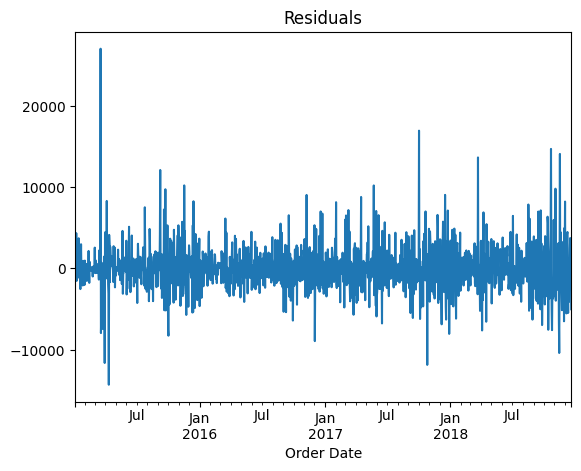

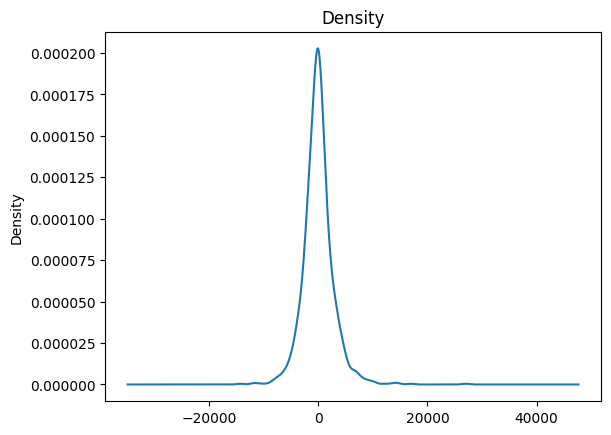

In [15]:
residuals = pd.DataFrame(sarimax_fit.resid)

residuals.plot(legend=False, title='Residuals')
residuals.plot(kind='density', title='Density', legend=False)

print(f"Residuals mean: {residuals.mean()}")
print(f"Residuals stdev: {residuals.std()}")

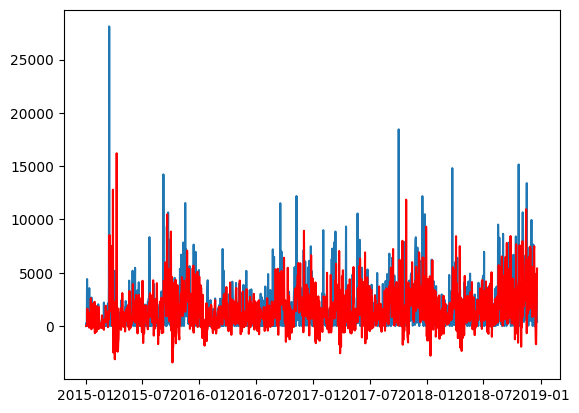

In [16]:
plt.figure()
plt.plot(train_data['Sales'], label='Actual')
plt.plot(sarimax_fit.get_prediction().predicted_mean, color='red', label='Predicted')

(array([17886., 17887., 17888., 17889., 17890., 17891., 17892., 17893.,
        17894., 17895.]),
 [Text(17886.0, 0, '2018-12-21'),
  Text(17887.0, 0, '2018-12-22'),
  Text(17888.0, 0, '2018-12-23'),
  Text(17889.0, 0, '2018-12-24'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17891.0, 0, '2018-12-26'),
  Text(17892.0, 0, '2018-12-27'),
  Text(17893.0, 0, '2018-12-28'),
  Text(17894.0, 0, '2018-12-29'),
  Text(17895.0, 0, '2018-12-30')])

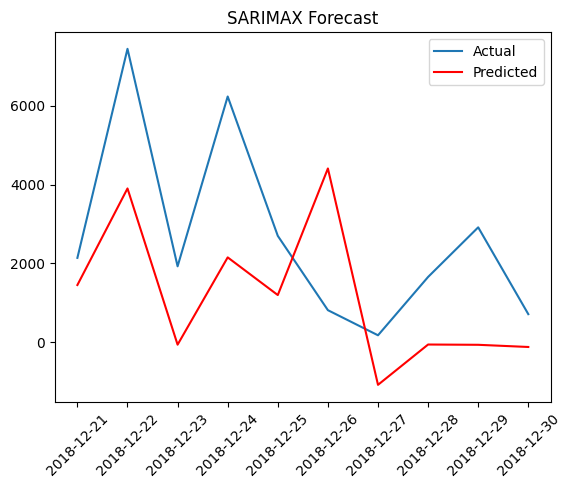

In [17]:
# Predict next 7 days
steps = end
forecast = sarimax_fit.get_forecast(steps=steps)
forecast_dates = pd.date_range(start=df.index[-steps], periods=steps, freq='D')
forecast = pd.DataFrame(forecast.predicted_mean.values, index=forecast_dates)
forecast.columns = ['Sales']

plt.figure()
plt.plot(df['Sales'].iloc[-end:], label='Actual')
plt.plot(forecast['Sales'], color='red', label='Predicted')

plt.title('SARIMAX Forecast')
plt.legend()
plt.xticks(rotation=45)
